# Вспомогательный код


Фиксируем seed для воспроизводимости результатов.

In [ ]:
import torch
import random
import numpy as np


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


set_random_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Задание 1. Классификация спутниковых снимков

В этом задании мы будем работать с [**EuroSAT Dataset**](https://github.com/phelber/eurosat). В датасете представлены космоснимки со спутника Sentinel-2, которые находятся в открытом и свободном доступе в рамках программы наблюдения Земли — Copernicus. Датасет охватывает 13 спектральных диапазонов и состоит из 10 классов с общим количеством 27 000 размеченых и привязанных к местности изображений.

Вам нужно обучить сеть и оценить качество модели. Напишите пошаговый план решения задачи.

In [ ]:
# данные надо нормализовать, 13 каналов, подумать как сделать
# датасет большой сразу все значения для нормализации не посмчитать, нужно подумать как сделать так чтобы частично посчитать
# использовать тимм, лайтнинг. необязательно обучать сеть с нуля
# посчитать метрики

## Формат результата


* Значение метрики

* Написанный пошаговый план



Импорт необходимых библиотек:

In [ ]:
# 13 каналов задача классификации


In [ ]:
!pip install -q torchsat
!pip install -q timm lightning torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 95.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 64.7 MB/s eta 0:00:00


In [ ]:
import timm
import torch
import numpy as np
import torchmetrics
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import DataLoader
from torchsat.datasets.eurosat import EuroSAT

## Загрузка данных

Воспользуемся пакетом [torchsat](https://torchsat.readthedocs.io/en/latest/index.html) для работы с датасетом

Загрузка данных в нем пока не поддерживается :( придется загрузить и распаковать архив самостоятельно:

In [ ]:
!mkdir -p /content/eurosat-ms
!wget -q https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/EuroSATallBands.zip
!unzip -q EuroSATallBands.zip -d /content/eurosat-ms
!rm EuroSATallBands.zip

In [ ]:
from torchsat.datasets.eurosat import EuroSAT

dataset = EuroSAT(root="/content/eurosat-ms/ds/", mode="AllBand")

## Предварительный анализ

Посмотрим, что мы скачали

In [ ]:
print("Image count: ", len(dataset))
image, label = dataset[0]
print("Type: ", type(image), "shape", image.shape, "Class", dataset.classes[label])

Image count:  27000
Type:  <class 'numpy.ndarray'> shape (64, 64, 13) Class AnnualCrop


In [ ]:
image.shape

(64, 64, 13)

Ага! У нас не 3 канала, как в обычном RGB, а аж целых 13! Давайте на них посмотрим

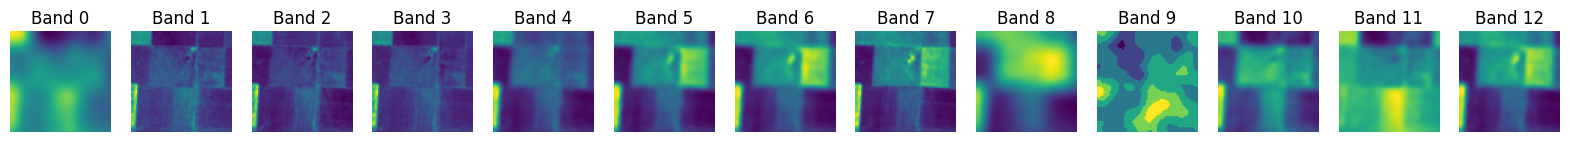

In [ ]:
fig, ax = plt.subplots(ncols=13, figsize=(20, 3))
for band, a in enumerate(ax):
    a.imshow(image[:, :, band])
    a.axis("off")
    a.set_title("Band %i" % band)

Что значат эти Bands?

* Band 0 – Coastal aerosol
* Band 1 – Blue
* Band 2 – Green
* Band 3 – Red
* Band 4–6 – Vegetation red edge
* Band 7 – NIR (near infrared range)
* Band 8 – Narrow NIR
* Band 9 – Water vapour
* Band 10–12 – SWIR (short wave infrared spectral range)

Вооружившись этим знанием, посмотрим на картинки снова:

Text(0.5, 0.98, 'AnnualCrop')

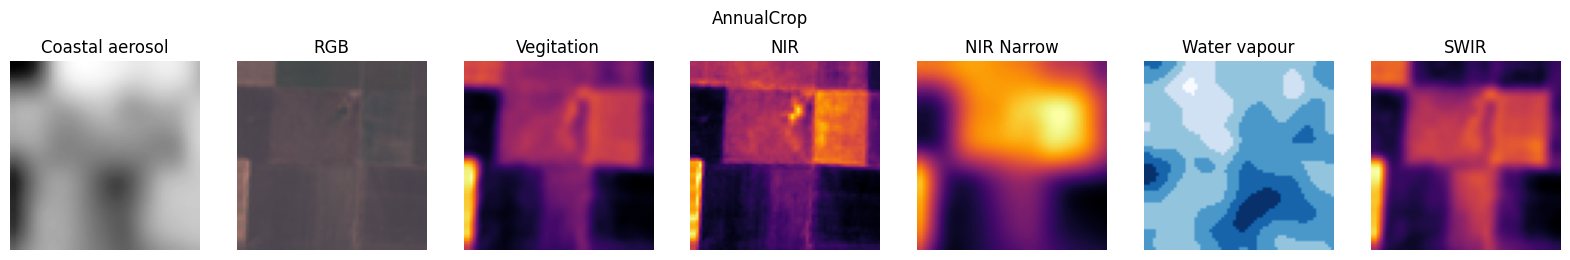

In [ ]:
fig, ax = plt.subplots(ncols=7, figsize=(20, 3))

ax[0].imshow(image[:, :, 0], cmap="Greys")
ax[0].set_title("Coastal aerosol")

# get 1 image from 3 channel
b = image[:, :, 1] / image[:, :1].max()  # Normalize at 0 to 1
g = image[:, :, 2] / image[:, :2].max()
r = image[:, :, 3] / image[:, :3].max()
rgb = np.stack((r, g, b))
rgb = np.moveaxis(rgb, [0, 1, 2], [2, 0, 1])  # 3,64,64 -> 64,64,3 like permute(1,2,0)

ax[1].imshow(rgb)
ax[1].set_title("RGB")

ax[2].imshow(image[:, :, 4:6].sum(axis=2), cmap="inferno")
ax[2].set_title("Vegitation")

ax[3].imshow(image[:, :, 7], cmap="inferno")
ax[3].set_title("NIR")

ax[4].imshow(image[:, :, 8], cmap="inferno")
ax[4].set_title("NIR Narrow")

ax[5].imshow(image[:, :, 9], cmap="Blues")
ax[5].set_title("Water vapour")

ax[6].imshow(image[:, :, 10:].sum(axis=2), cmap="inferno")
ax[6].set_title("SWIR")
for a in ax:
    a.axis("off")

plt.suptitle(dataset.classes[label])

##  Посмотрите какие есть классы в нашем `dataset`

In [ ]:
help(dataset)

In [ ]:
# Your code here
dataset.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

## Подготовка к обучению



Разобьем датасет на Train, Validation и Test и инициализируем загрузчики

In [ ]:
train_set, val_set, test_set = torch.utils.data.random_split(
    dataset,
    [int(len(dataset) * 0.7), int(len(dataset) * 0.15), int(len(dataset) * 0.15)],
)

Предобработайте данные, создайте загрузчики (Dataloaders)

In [ ]:
# Your code here
num_epochs = 10
batch_size = 256
learning_rate = 1e-3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True) # Your code here
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)  # Your code here
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)  # Your code here

Dataloader не сможет преобразовать uint16 numpy массив к тензору и выдаст ошибку. Стандартный ToTensor рассчитан на работу с картинками, где значения яркости находятся в интервале 0 .. 255, и тоже не сработает. Придется добавить к датасету трансформацию, которая преобразует значения во float, например, так.

In [ ]:
dataset.transform = transforms.Compose([lambda np_arr: np_arr.astype(float)])

In [ ]:
batch_mean = []
batch_std = []
loader = DataLoader(dataset, batch_size=256, shuffle=True)

for im, l in loader:
    batch_mean.append(im.mean((2, 0, 1)))  # batch_size x H x W
    batch_std.append(im.std((2, 0, 1)))

mean = np.stack(batch_mean).mean(0)  # batch_count x 13 -> 13
std = np.stack(batch_std).mean(0)

In [ ]:
mean.shape

(13,)

In [ ]:
std.shape

(13,)

In [ ]:
from torchvision import transforms  # models, datasets,

dataset.transform = transforms.Compose([lambda np_arr: np_arr.astype(float),
                                        lambda np_array: torch.from_numpy(np_array).permute(2, 0, 1).float(),
                                        #transforms.ToTensor(),
                                        transforms.Normalize(mean, std)
                                        ])

Не забудьте сделать другие преобразования. На вход нейросети нужно подать тензор с размерностью (batсh, C, H, W).


##  Обучите сеть



In [ ]:
model_name = "efficientnet_b5.sw_in12k_ft_in1k"

pretrained_model = timm.create_model(model_name, pretrained=True, num_classes=10, in_chans=13).to(device)

print(pretrained_model)

model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2d(13, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
   

In [ ]:
tmp = timm.create_model(model_name, pretrained=True)
print(tmp)

EfficientNet(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
    

In [ ]:
num_in_features = pretrained_model.get_classifier().in_features
num_in_features

2048

In [ ]:
from torchsummary import summary
summary(pretrained_model, (13, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           5,616
          Identity-2           [-1, 48, 32, 32]               0
              SiLU-3           [-1, 48, 32, 32]               0
    BatchNormAct2d-4           [-1, 48, 32, 32]              96
            Conv2d-5           [-1, 48, 32, 32]             432
          Identity-6           [-1, 48, 32, 32]               0
              SiLU-7           [-1, 48, 32, 32]               0
    BatchNormAct2d-8           [-1, 48, 32, 32]              96
            Conv2d-9             [-1, 12, 1, 1]             588
             SiLU-10             [-1, 12, 1, 1]               0
           Conv2d-11             [-1, 48, 1, 1]             624
          Sigmoid-12             [-1, 48, 1, 1]               0
    SqueezeExcite-13           [-1, 48, 32, 32]               0
           Conv2d-14           [-1, 24,

In [ ]:
import lightning as L
from torch import optim
import torchmetrics

class LitBasic(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.valid_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.loss_func = nn.CrossEntropyLoss()
        # Your code here

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.model.parameters(), momentum=0.9, lr=1e-3)# Your code here
        return optimizer

    def training_step(self, batch, batch_idx):
        # Your code here
        image, labels = batch
        pred= self.model(image)
        loss = self.loss_func(pred, labels)
        preds = torch.argmax(pred, dim=1)

        self.train_acc.update(preds, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        image, labels = batch
        pred = self.model(image)
        loss = self.loss_func(pred, labels)
        preds = torch.argmax(pred, dim=1)

        self.valid_acc.update(preds, labels)
        self.log('valid_loss', loss)

    def on_train_epoch_end(self):
        self.log('train_acc', self.train_acc.compute(), prog_bar=True)
        self.train_acc.reset()

    def on_validation_epoch_end(self):
        self.log('valid_acc', self.valid_acc.compute(), prog_bar=True)
        self.valid_acc.reset()


In [ ]:
class LitTest(LitBasic):

    def __init__(self, model):
        super().__init__(model)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

    def test_step(self, batch, batch_idx):
        # Your code here
        image, labels = batch
        pred = self.model(image)
        loss = self.loss_func(pred, labels)
        preds = torch.argmax(pred, dim=1)

        self.test_acc.update(preds, labels)
        self.log('test_loss', loss)
        return loss

    def on_test_epoch_end(self):
        # Your code here
        self.log('test_acc', self.test_acc.compute(), prog_bar=True)
        self.test_acc.reset()

In [ ]:
# Init logger
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger(save_dir='./logs', name='my_model')
# Your code here

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Your code here
L.seed_everything(42)
lit_model = LitBasic(pretrained_model)
if torch.cuda.is_available():
    pretrained_model.cuda()
trainer = L.Trainer(logger=logger, max_epochs=10, log_every_n_steps=5)
trainer.fit(model=lit_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params
-------------------------------------------------
0 | model     | EfficientNet       | 28.4 M
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
28.4 M    Trainable params
0         Non-trainable params
28.4 M    Total params
113.462   Total estimated model params size (MB)
INFO:lightning.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# Your code here

##  Оцените точность

Оцените точность своей модели

In [ ]:
# Your code here

In [ ]:
lit_model_test = LitTest(pretrained_model)
trainer.test(model=lit_model_test, dataloaders=test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8246913552284241     │
│         test_loss         │    0.5688648819923401     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5688648819923401, 'test_acc': 0.8246913552284241}]

## Напишите пошаговый план

*Ваш текст здесь*

1. После загрузки данных, предобрабатываем данные, делаем DataLoaders. К датасету применяем трансформации: преобразуем значения во float, переставляем CHW - HWC, делаем нормализацию (для этого пришлось отдельно рассчитать mean и std).
2. В качестве модели была выбрана предобученная модель efficientnet_b5.sw_in12k_ft_in1k из библиотеки timm, в которой я заменил число выходных классов и входных каналов на 10 и 13 соответственно. Выбор модели был обусловлен рекомендацией на лекции использовать EfficientNet, а конкретная модель выбиралась по перфомансу в задаче топ-1 и первая среди моделей, где в названии нет tf (было мнение, что это может вызывать ошибку float/double). Данная модель в задаче топ-1 имеет 85.896.
3. Предобученную модель дообучили на датасете EuroSAT, использовали lightning. За 10 эпох получили на тесте 0.825 accuracy. Думаю, результат был бы лучше при заморозке внутренних слоев модели, обучении только входного и выходного слоев, а затем применении fine tuning.

# Задание 2. CustomResNet

In [ ]:
# прочитать статью, понять, что сделано для цифар-10, применит. главы 4.2. аугментации не надо

Требуется самостоятельно реализовать свёрточную сеть на базе архитектуры ResNet-18, описанной в статье [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385).

Создайте свою собственную сеть на основе архитектуры ResNet, описанной в лекции. От 15  до 25 слоев.

Используйте заготовки классов `CustomResnet`, `BasicBlock`.

Прежде чем приступать к работе, просмотрите оригинальную [статью](https://arxiv.org/pdf/1512.03385.pdf).

*Не допускается целиком копировать код из исходников [PyTorch](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py).

**Если вы используете готовый фрагмент кода, то должны быть приведены ссылка на источник и комментарии.


## Формат результата

* Графики loss и accuracy при обучении

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX08/result_2_task_ex08.png" width="1200" >

* Значение accuracy на тесте должно составить не менее 0.77
* Сравнительный анализ результатов точности вашей модели и библиотечной версии.

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q timm lightning torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 91.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 48.2 MB/s eta 0:00:00


In [ ]:
import timm
import torch
import torchmetrics
import torch.nn as nn
import lightning as pl

from torchsummary import summary
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torchvision import models, datasets, transforms

## Структура модели

Прежде чем создавать собственную сеть, посмотрите архитектуру ResNet-18 из "Зоопарка моделей" PyTorch. Для этого используйте пакет [torchsummary](https://pypi.org/project/torch-summary/) или метод [add_graph](https://pytorch.org/docs/stable/tensorboard.html?highlight=add_graph#torch.utils.tensorboard.writer.SummaryWriter.add_graph) для TensorBoard.

In [ ]:
from torchvision.models import resnet18
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Your code here

model = resnet18()
print("ResNet-18 architecture")
print(summary(model, (3, 224, 224), device='cpu'))

ResNet-18 architecture
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReL

## Загрузка данных

Блок кода, отвечающий за загрузку данных.
Можно использовать без внесения изменений.

In [ ]:
# Load and preprocess the data. Don't change this code

# https://github.com/facebookarchive/fb.resnet.torch/issues/180
cifar10_mean = (0.491, 0.482, 0.447)
cifar10_std = (0.247, 0.244, 0.262)


# Data preprocessing
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # PIL Image to Pytorch tensor [0..255]->[0 .. 1]
        transforms.Normalize(
            cifar10_mean, cifar10_std
        ),  # https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transforms%20normalize#torchvision.transforms.Normalize
    ]
)

cifar_train = datasets.CIFAR10(
    "content", train=True, transform=transform, download=True
)
train_set, val_set = torch.utils.data.random_split(cifar_train, [45000, 5000])

Files already downloaded and verified


Рекомендуется делать всю отладку на небольших фрагментах датасета, для чего создать объекты класса `Subset` и  соответствующие Dataloader-объекты.


```
mini_trainset , _ = torch.utils.data.random_split(trainset, [5000, 45000])
mini_testset, _  = torch.utils.data.random_split(testset, [1000, 9000])
...

```



In [ ]:
cifar_test = datasets.CIFAR10(
    "content", train=False, transform=transform, download=True
)

mini_trainset, _ = torch.utils.data.random_split(train_set, [5000, 40000])
mini_valset, _ = torch.utils.data.random_split(val_set, [1000, 4000])
mini_testset, _  = torch.utils.data.random_split(cifar_test, [1000, 9000])

Files already downloaded and verified


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install -q GPUtil

  Preparing metadata (setup.py) ... done


In [ ]:
import GPUtil as GPU
import psutil
import os


def gpu_usage():
    GPUs = GPU.getGPUs()
    # XXX: only one GPU on Colab and isn’t guaranteed
    if len(GPUs) == 0:
        return False
    gpu = GPUs[0]
    process = psutil.Process(os.getpid())
    print(
        f"GPU RAM Free: {gpu.memoryFree:.0f}MB \
    | Used: {gpu.memoryUsed:.0f}MB \
    | Util {gpu.memoryUtil*100:3.0f}% \
    | Total {gpu.memoryTotal:.0f}MB"
    )

Очистка памяти:

In [ ]:
gpu_usage()

GPU RAM Free: 13826MB     | Used: 1275MB     | Util   8%     | Total 15360MB


## Блок кода для обучения

Можно воспользоваться [кодом](https://github.com/Gan4x4/ml_snippets/blob/main/Training/Trainer.ipynb) из прошлых лекций


In [ ]:
import torch.optim as optim
import torch

In [ ]:
# compute on cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch

def get_correct_count(pred, labels):
  _, predicted = torch.max(pred.data, 1)
  return (predicted.cpu() == labels.cpu()).sum().item()

@torch.inference_mode()
def calculate_accuracy(model, data_loader, criterion, device):
    correct, total = 0, 0
    loss = 0
    for batch in data_loader:
        imgs, labels = batch
        pred = model(imgs.to(device))
        loss += criterion(pred, labels.to(device))
        correct += get_correct_count(pred, labels.to(device))
        total += labels.size(0)

    return round((correct / total), 2) , round((loss.item() / len(data_loader)), 4)

def train_epoch(model, optimizer, criterion, train_loader):
    loss_history = []
    for batch in train_loader:
        optimizer.zero_grad()
        x_train, y_train = batch  # parse data
        x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
        y_pred = model(x_train)  # get predictions
        loss = criterion(y_pred, y_train)  # compute loss
        loss_history.append(loss.cpu().detach().item())  # write loss to log
        loss.backward()
        optimizer.step()
    return loss_history

def validate(model, criterion, val_loader):
    cumloss = 0
    loss_history = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train = batch  # parse data
            x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
            y_pred = model(x_train)  # get predictions
            loss = criterion(y_pred, y_train)  # compute loss
            loss_history.append(loss.cpu().detach().item())  # write loss to log
            cumloss += loss
    return cumloss / len(val_loader), loss_history  # mean loss and history

In [ ]:
from tqdm.notebook import tqdm


def train_model(model, optimizer, model_name=None, num_epochs=20):
    criterion = nn.CrossEntropyLoss().to(device)

    train_history = {}
    train_history["model_name"] = model_name
    train_history["epoсhs"] = num_epochs
    train_history["loss_on_train"] = []
    train_history["loss_on_test"] = []
    train_history["accuracy"] = []

    for epoch in tqdm(range(num_epochs)):
        loss_on_train = train_epoch(model, optimizer, criterion, train_loader)
        _, loss_on_test = validate(model, criterion, test_loader)
        train_history["loss_on_train"].extend(loss_on_train)
        train_history["loss_on_test"].extend(loss_on_test)
        accuracy, loss_val = calculate_accuracy(model, val_loader, criterion, device)
        train_history["accuracy"].append(accuracy)
    return train_history

In [ ]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np


class ProgressPlotter:
    """
    Groups contain a list of variables to output, like ["loss", "accuracy"]
    If group is None all variables will be plotted

    Title is expariment_id like "Relu_Adam_lr003"
    All new collected data binded to current title
    """

    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
            if len(data) > 1:
                ax.legend(loc="upper right")
            if history_len < 50:
                ax.set_xlabel("step")
                ax.set_xticks(np.arange(history_len))
                ax.set_xticklabels(np.arange(history_len))

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(48 // n_groups, 3))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

Код для визуализации из прошлых заданий, можно заменить его собственым.

## Основная часть задания

Создайте свою собственную сеть на основе архитектуры ResNet, описанной в лекции. От 15  до 25 слоев.

Используйте заготовки классов `CustomResnet`, `BasicBlock`.

Прежде чем приступать к работе, просмотрите оригинальную [статью](https://arxiv.org/pdf/1512.03385.pdf).

Не допускается копировать код из исходников [PyTorch](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py).

Если вы используете готовый фрагмент кода, то должна быть приведена ссылка на источник и комментарии.

Цель — добиться точности > 0.76.
При разумной архитектуре и гиперпараметрах для этого достаточно 20 эпох.

In [ ]:
class CustomResnet(nn.Module):
    def __init__(self, class_nums=10):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.layer0 = self._make_layer(64, blocks=3, stride=2)
        self.layer1 = self._make_layer(128, blocks=3, stride=2)
        self.layer2 = self._make_layer(512, blocks=4, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, class_nums)

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=4),
                nn.BatchNorm2d(out_channels),
            )
        layers = []
        layers.append(
            BasicBlock(
                self.in_channels, out_channels, stride, downsample
            )
        )
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(BasicBlock(
                self.in_channels,
                out_channels, stride=1, downsample=None
            ))
        return nn.Sequential(*layers)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.maxpool(batch)
        batch = self.layer0(batch)
        batch = self.layer1(batch)
        batch = self.layer2(batch)
        batch = self.avgpool(batch)
        batch = torch.flatten(batch, 1)
        scores = self.fc(batch)

        return scores

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

## Обучите вашу модель на CIFAR-10

Не забудьте вернуть в датасет данные, если вы удаляли их для ускорения отладки.

Оптимизатор, количество эпох, шаг обучения, критерий останова выберите на свое усмотрение.

Цель — добиться точности, лучшей, чем в прошлом задании.

In [ ]:
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False)
test_loader = DataLoader(cifar_test, batch_size=256, shuffle=False)

In [ ]:
%%time
custom_resnet = CustomResnet(10).to(device)
optimizer = optim.AdamW(custom_resnet.parameters(), lr=0.001)
custom_resnet_model = train_model(custom_resnet, optimizer, model_name="custom_resnet")

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 6min 45s, sys: 1.27 s, total: 6min 46s
Wall time: 6min 50s


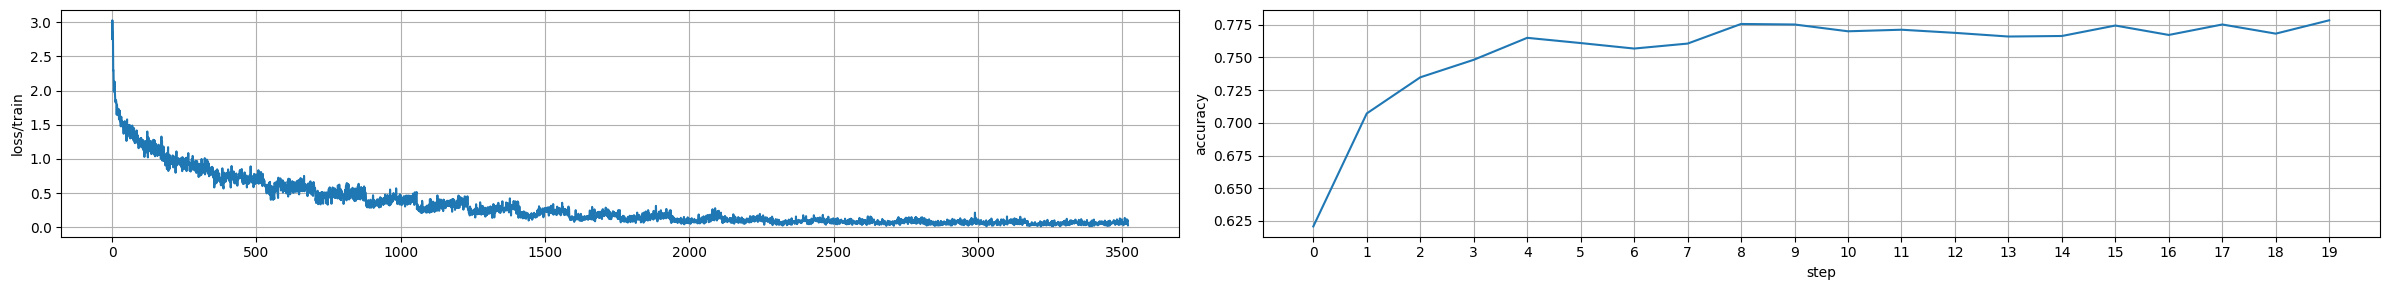

In [ ]:
pplotter = ProgressPlotter()
pplotter.set_title('ResNet')
for i in range(len(custom_resnet_model['loss_on_train'])):
    pplotter.add_scalar('loss/train', custom_resnet_model['loss_on_train'][i])
for i in range(len(custom_resnet_model['accuracy'])):
    pplotter.add_scalar('accuracy', custom_resnet_model['accuracy'][i])
pplotter.display(['loss/train', 'accuracy'])

Проверьте качество на тестовой части датасета.

In [ ]:
print('Accuracy, loss')
calculate_accuracy(custom_resnet, test_loader, nn.CrossEntropyLoss().to(device), device)

Accuracy, loss


(0.77, 1.2382)

## Обучите ResNet-18

Теперь обучите ResNet-18  из `torchvision.models` на том же CIFAR-10.
Используйте непредобученную модель (`weights = None`)

Для обучения на CIFAR-10 потребуется изменить параметры линейного слоя на выходе модели, так как в этом датасете 10 классов, а не 1000, как в ImageNet.

Пример того, как можно подменить слой, можно найти [здесь](https://github.com/Gan4x4/CV-HSE2019/blob/master/helloworld/Change_model_structure.ipynb)

После завершения обучения сравните точность вашей модели с точностью ResNet-18  из `torchvision.models`, а также с точностью, полученной авторами статьи на CIFAR-10:

<img src = "https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX08/resnet_accuracy.png" width="600">

In [ ]:
from torchvision.models import resnet18

resnet_original = resnet18(weights=None).to(device)


In [ ]:
resnet_original.fc = nn.Linear(512, 10).to(device)

In [ ]:
%%time
optimizer = optim.AdamW(resnet_original.parameters(), lr=0.001)
resnet_original_model = train_model(resnet_original, optimizer, model_name="resnet_original")

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 6min 18s, sys: 1.17 s, total: 6min 19s
Wall time: 6min 22s


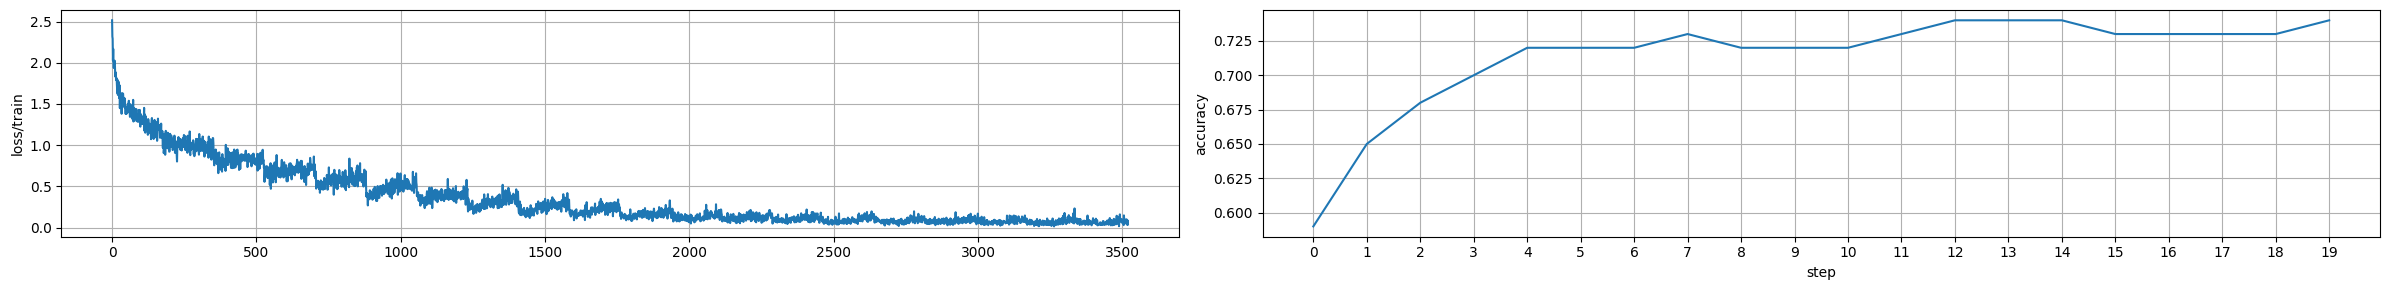

In [ ]:
pplotter = ProgressPlotter()
pplotter.set_title('ResNet_original')
for i in range(len(resnet_original_model['loss_on_train'])):
    pplotter.add_scalar('loss/train', resnet_original_model['loss_on_train'][i])
for i in range(len(resnet_original_model['accuracy'])):
    pplotter.add_scalar('accuracy', resnet_original_model['accuracy'][i])
pplotter.display(['loss/train', 'accuracy'])

Оценим точность библиотечной модели на test

In [ ]:
print('Accuracy, loss')
calculate_accuracy(resnet_original, test_loader, nn.CrossEntropyLoss().to(device), device)

Accuracy, loss


(0.73, 1.4349)

## Вывод:

Сравнительный анализ результатов точности вашей модели и библиотечной версии.

Моя модель оказалась немного точнее библиотечной версии ResNet18, хотя и в том, и в другом случае она ниже точности, продемонстрированной в статье (возможно, это связано с примененной авторами подстройкой скорости обучения и другим оптимизатором). Возможно, некоторый выигрыш в точности произошел за счет исключения 256-блока.


